- 1 Introduction
- 2 Load and check data
    - 2.1 load data
    - 2.2 Outlier detection
    - 2.3 joining train and test set
    - 2.4 check for null and missing values
- 3 Feature analysis
    - 3.1 Numerical values
    - 3.2 Categorical values
- 4 Filling missing Values
    - 4.1 Age
- 5 Feature engineering
    - 5.1 Name/Title
    - 5.2 Family Size
    - 5.3 Cabin
    - 5.4 Ticket
- 6 Modeling
    - 6.1 Simple modeling
        - 6.1.1 Cross validate models
        - 6.1.2 Hyperparamater tunning for best models
        - 6.1.3 Plot learning curves
        - 6.1.4 Feature importance of the tree based classifiers
    -  6.2 Ensemble modeling
        - 6.2.1 Combining models
    -6.3 Prediction
        - 6.3.1 Predict and Submit results

# 1. Introduction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier,ExtraTreesClassifier,VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# LDA 선형 판별 분석
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier # 다층 신경망
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score,StratifiedKFold,learning_curve

sns.set(style='white', context='notebook',palette='deep')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# 2. Load and check data

## 2-1. Load data

In [2]:
train = pd.read_csv("../input/titanic/train.csv")
test = pd.read_csv("../input/titanic/test.csv")
IDtest = test["PassengerId"]

## 2-2. Outlier detection

In [3]:
def detect_outliers(df,n,features):
    outlier_indices  = []

    for col in features:
        Q1 = np.percentile(df[col],25)
        Q3 = np.percentile(df[col],75)
        IQR = Q3-Q1

        outlier_step = 1.5 * IQR

        outlier_list_col = df[(df[col]<Q1 - outlier_step) | (df[col]>Q3+outlier_step)].index
        outlier_indices .extend(outlier_list_col)

    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k,v in outlier_indices.items() if v>n )

    return multiple_outliers

Outliers_to_drop = detect_outliers(train,2,["Age","SibSp",'Parch',"Fare"])

Outlier는 예측에 영향을 미칠 수 있으므로 관리하기로 결정함.

Age, SibSp, Parch, Fare에서 이상치를 감지하기로 결정하고 이상치가 두개 이상인 행을 이상치 행으로 결정함.

In [4]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


10개의 outliers를 발견했음.
- 28, 89, 342 승객은 높은 Ticket Fare 값을 가지고 있음
- 다른 7명은 SibSp의 값이 높음.

In [5]:
# Drop outliers
train = train.drop(Outliers_to_drop,axis = 0).reset_index(drop=True)

## 2-3. Joining train and test set

In [6]:
train_len = len(train)
dataset = pd.concat(objs = [train,test],axis =0).reset_index(drop=True)

훈련 데이터셋과 테스트 데이터셋을 join함 범주형 변환하는 동안 같은 수의 feature를 얻기 위해

## 2-4. Check for null and missing values

In [7]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# check for null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

Age와 Cabin feature는 결측값의 대부분을 차지함.

Survived의 결측값은 테스트데이터셋에 해당됨.

In [8]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [11]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# 3. Feature analysis

## 3-1. Numerical values

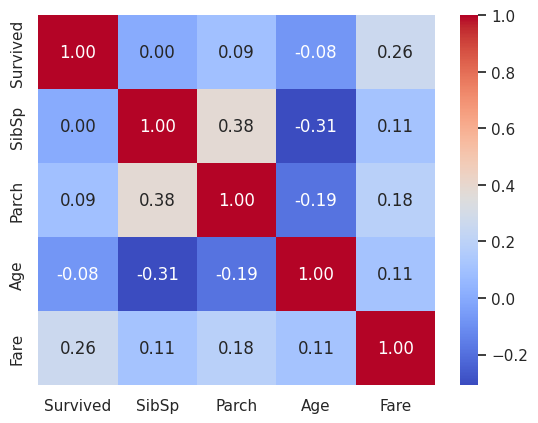

In [12]:
g= sns.heatmap(train[['Survived','SibSp','Parch','Age','Fare']].corr(),annot=True, fmt = ".2f",cmap="coolwarm")

Fare만 Survived와 유의미한 상관관계가 있는 것으로 보임.

다른 feature이 유용하지 않다는 의미는 아님. 이러한 feature의 하위 모집단은 Survived와 상관관계가 있을 수 있음. 이를 결정하기 위해서는 feature를 자세히 살펴봐야함.

### 3-1-1. SibSp

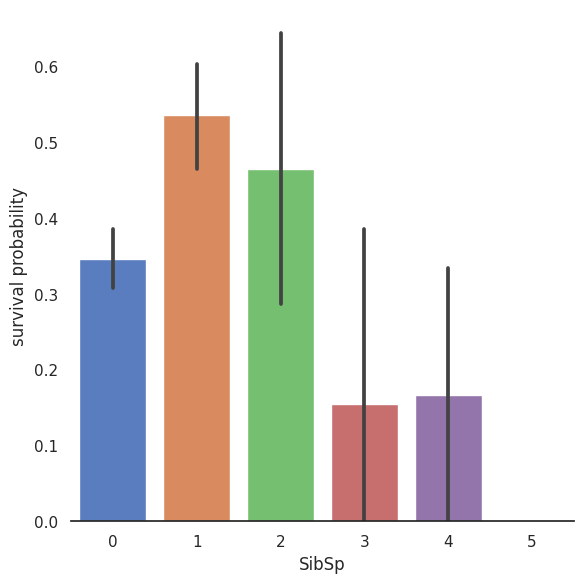

In [13]:
g = sns.catplot(x="SibSp",y="Survived",data=train,kind="bar",height=6,palette="muted")
g.despine(left=True) # 위쪽 축과 오른쪽 축을 숨김.
g = g.set_ylabels("survival probability")

- 형제, 배우자가 많은 승객은 생존 가능성이 적은 것으로 보임.
- 한명의 승객(0 SibSp) 또는 다른 두명의 승객 (SibSp 1 or 2)는 생존할 확률이 높음.

### 3-1-2. Parch

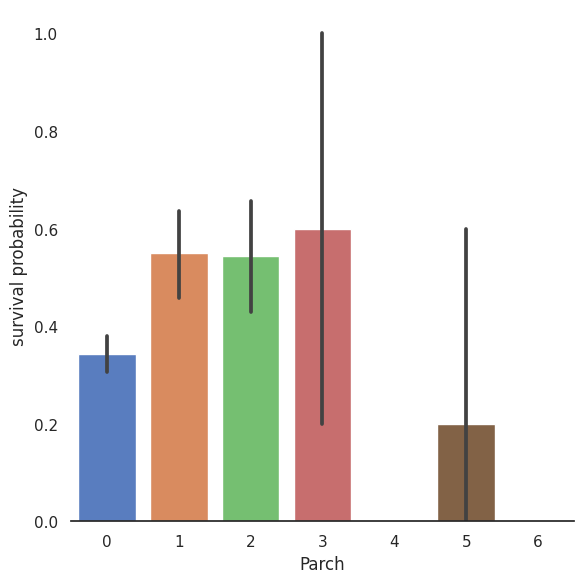

In [14]:
g = sns.catplot(x="Parch", y = "Survived", data = train, kind= "bar", height = 6, palette= "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

- 소규모 가족은 생존확률이 더 높음. 독신(Parch 0), 중간(Parch 3,4), 대가족(Parch 5,6)
- 부모/자녀가 3명인 승객의 생존에는 표준편차가 매우 크기 때문에 주의 해야함.

### 3-1-3. Age

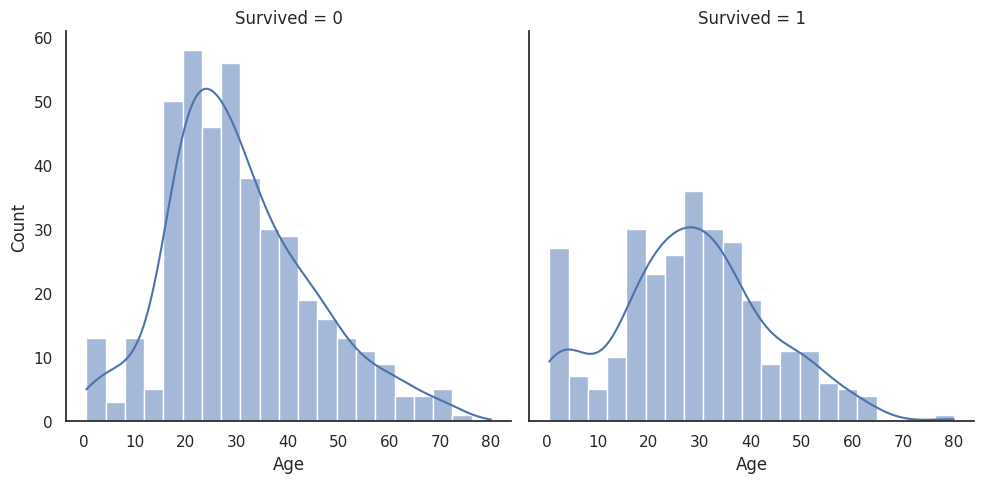

In [15]:
# Explore Age vs Survived
sns.displot(data = train, x ="Age", col = "Survived",kde = True)

- 생존한 집단과 생존하지 않은 집단의 연령 분포가 같지 않은 것을 확인할 수 있음.
- 실제로 젊은 승객에 해당하는 정점이 생존한 것으로 나타남.
- 또한 60-80세 사이의 승객이 생존한 경우가 적다는 것도 알 수 있음.
- 따라서 연령이 생존과 상관관계가 없더라도 생존 가능성이 어느 정도 높은 승객의 연령 범주가 있다는 것을 알 수 있음

- 아주 어린 승객은 생존할 수 있는 기회가 더 많은 것으로 보임.

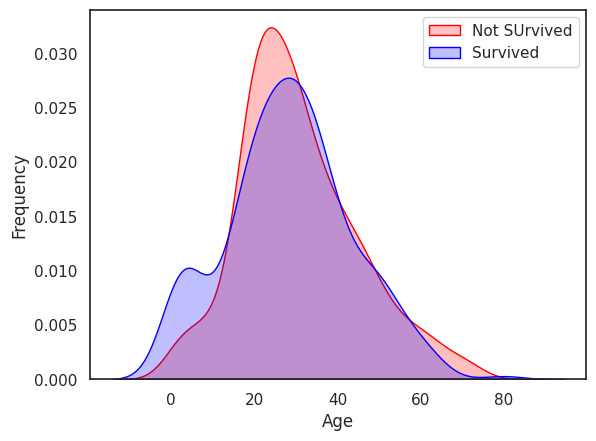

In [16]:
g = sns.kdeplot(train["Age"][(train["Survived"]==0) & (train["Age"].notnull())],
               color = "Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"]==1) & (train["Age"].notnull())],
               color = "Blue", shade = True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not SUrvived", "Survived"])

### 3-1-4. Fare

In [17]:
dataset["Fare"].isnull().sum()

1

In [18]:
# Fill Fare missing values with the median value

dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

In [19]:
# g = sns.displot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
# g = g.legend(loc="best")

- Fare의 분포는 매우 왜곡되어있음. 이로 인해 규모가 축소되더라도 모데레서 가중치가 매우 높을 수 있음.
- 로그 함수로 변환하여 왜곡을 줄이는 것이 좋음.

## 3-2. Categorical values

### 3-2-1. Sex